In [7]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adile45/coco-cat-subset")

# print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import os
import glob
from PIL import Image

class CatSuperRes(Dataset):
    def __init__(self, root_dir, split="train", limit=2000): # Limit added
        print(f"Initializing dataset (split={split})...")
        # Suche rekursiv nach Bildern
        self.image_paths = []
        # Suche nach gängigen Bildformaten
        for ext in ['*.jpg', '*.jpeg', '*.png']:
            self.image_paths.extend(glob.glob(os.path.join(root_dir, '**', ext), recursive=True))
        
        self.image_paths.sort()
        
        # Limit dataset size for speed
        if limit and len(self.image_paths) > limit:
            print(f"  [Info] Limiting dataset to {limit} images (original: {len(self.image_paths)})")
            self.image_paths = self.image_paths[:limit]
        
        # Split 60/40 (train/val)
        split_idx = int(0.6 * len(self.image_paths))
        if split == "train":
            self.image_paths = self.image_paths[:split_idx]
        else:  # val
            self.image_paths = self.image_paths[split_idx:]
            
        print(f"  -> Found {len(self.image_paths)} images for {split}.")

        # Transform: Erst auf eine Mindestgröße bringen, dann Random Crop für High-Res Details
        self.target_size = 128 # Reduced from 256 for speed
        
        self.transform = transforms.Compose([
            # Falls ein Bild kleiner als target_size ist, vergrößern wir die kurze Seite
            transforms.Resize(self.target_size), 
            # Wir schneiden ein zufälliges Stück aus
            transforms.RandomCrop((self.target_size, self.target_size)),
            # Data Augmentation: Random Flip
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])
        
        # Downsampling mit Resize (Bicubic) statt MaxPool
        # Low Res ist halb so groß wie High Res
        self.downsample = transforms.Resize((self.target_size // 2, self.target_size // 2), interpolation=transforms.InterpolationMode.BICUBIC)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Debug output (throttled) - zeigt Aktivität, ohne zu fluten
        # Da shuffle=True ist, kommen die Indizes zufällig.
        if idx % 200 == 0:
             print(f"  [Dataset] Loading image index {idx} (sample check)")

        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB") # Sicherstellen, dass es RGB ist
        
        high_res = self.transform(img)      # (3, 128, 128)
        low_res = self.downsample(high_res) # (3, 64, 64)
        
        return low_res, high_res

In [9]:
print("Setting up datasets...")
train_ds = CatSuperRes(root_dir=path, split="train")
val_ds   = CatSuperRes(root_dir=path, split="val")

print("Setting up DataLoaders...")
# pin_memory=True speeds up host to device transfer
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, pin_memory=True)
print("DataLoaders ready.")

Setting up datasets...
Initializing dataset (split=train)...
  [Info] Limiting dataset to 2000 images (original: 4298)
  -> Found 1200 images for train.
Initializing dataset (split=val)...
  [Info] Limiting dataset to 2000 images (original: 4298)
  -> Found 800 images for val.
Setting up DataLoaders...
DataLoaders ready.
  [Info] Limiting dataset to 2000 images (original: 4298)
  -> Found 800 images for val.
Setting up DataLoaders...
DataLoaders ready.


In [10]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class ResNetSR(nn.Module):
    def __init__(self, num_res_blocks=4, channels=64):
        super(ResNetSR, self).__init__()
        
        # Initial Feature Extraction
        self.conv1 = nn.Conv2d(3, channels, kernel_size=9, padding=4)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual Blocks
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(channels) for _ in range(num_res_blocks)]
        )
        
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
        # Upsampling (PixelShuffle)
        # 128 -> 256 (2x upsampling)
        self.conv3 = nn.Conv2d(channels, channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.relu2 = nn.ReLU(inplace=True)
        
        # Final Output
        self.conv4 = nn.Conv2d(channels, 3, kernel_size=9, padding=4)
        
    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.res_blocks(out1)
        out = self.bn2(self.conv2(out))
        out += out1 # Global Skip Connection
        
        out = self.conv3(out)
        out = self.pixel_shuffle(out)
        out = self.relu2(out)
        
        out = self.conv4(out)
        out = torch.sigmoid(out) # Output in [0, 1]
        return out

Using device: cuda
Preparing visualization batch...
  [Dataset] Loading image index 0 (sample check)
Visualization batch ready.
Starting training loop...
Epoch 1/15 - Training phase started. Waiting for first batch...
Visualization batch ready.
Starting training loop...
Epoch 1/15 - Training phase started. Waiting for first batch...
  [Epoch 1] First batch loaded! Processing...
  [Epoch 1] First batch loaded! Processing...
  [Epoch 1] Train Batch 1/19 processed
  [Dataset] Loading image index 200 (sample check)
  [Epoch 1] Train Batch 1/19 processed
  [Dataset] Loading image index 200 (sample check)
  [Epoch 1] Train Batch 2/19 processed
  [Epoch 1] Train Batch 2/19 processed
  [Epoch 1] Train Batch 3/19 processed
  [Epoch 1] Train Batch 3/19 processed
  [Epoch 1] Train Batch 4/19 processed
  [Dataset] Loading image index 1000 (sample check)
  [Epoch 1] Train Batch 4/19 processed
  [Dataset] Loading image index 1000 (sample check)
  [Epoch 1] Train Batch 5/19 processed
  [Epoch 1] Trai

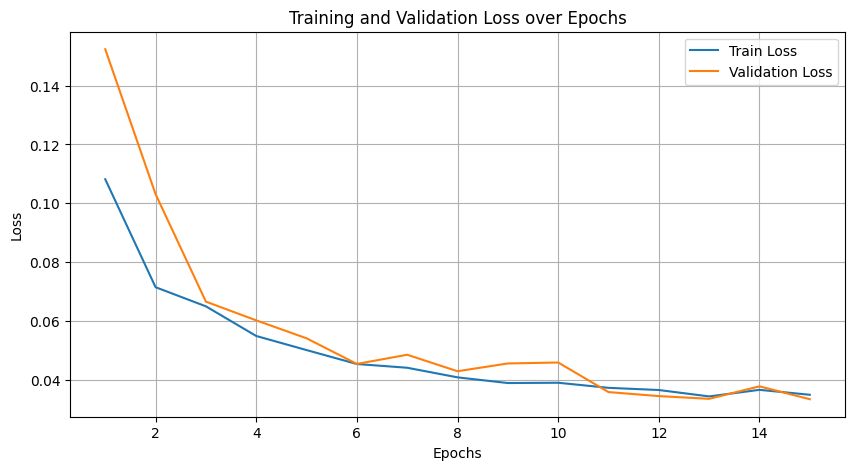

In [11]:
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ResNetSR().to(device)
criterion = nn.L1Loss() # L1 Loss ist oft besser für Schärfe als MSE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 15 # Reduced from 15 for speed

# Listen für Loss-Werte initialisieren
train_losses = []
val_losses = []

print("Preparing visualization batch...")
# Ein festes Bild für die Visualisierung auswählen (z.B. das erste aus dem Validation Loader)
# Wir nehmen einen Batch und picken das erste Bild heraus
fixed_low_batch, fixed_high_batch = next(iter(val_loader))
fixed_low_img = fixed_low_batch[0].unsqueeze(0).to(device)   # (1, 3, 64, 64)
fixed_high_img = fixed_high_batch[0].unsqueeze(0).to(device) # (1, 3, 128, 128)
print("Visualization batch ready.")

print("Starting training loop...")
for epoch in range(num_epochs):
    start_time = time.time()
    # Training Phase
    model.train()
    train_loss = 0.0
    
    print(f"Epoch {epoch+1}/{num_epochs} - Training phase started. Waiting for first batch...")
    for batch_idx, (low_res, high_res) in enumerate(train_loader):
        # Sobald wir hier sind, wurden die Daten für den Batch geladen
        if batch_idx == 0:
            print(f"  [Epoch {epoch+1}] First batch loaded! Processing...")

        low_res  = low_res.to(device)
        high_res = high_res.to(device)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * low_res.size(0)
        
        # Print status frequently at the beginning, then every 10 batches
        if batch_idx < 5 or (batch_idx + 1) % 10 == 0:
             print(f"  [Epoch {epoch+1}] Train Batch {batch_idx+1}/{len(train_loader)} processed")

    scheduler.step()
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss) # Loss speichern
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs} - Validation phase started")
    
    with torch.no_grad():
        for batch_idx, (low_res, high_res) in enumerate(val_loader):
            low_res  = low_res.to(device)
            high_res = high_res.to(device)
            
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            
            val_loss += loss.item() * low_res.size(0)
            
            # Print status every 10 batches
            if (batch_idx + 1) % 10 == 0:
                print(f"  [Epoch {epoch+1}] Val Batch {batch_idx+1}/{len(val_loader)} processed")
    
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss) # Loss speichern
    
    current_lr = optimizer.param_groups[0]['lr']
    
    epoch_duration = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} Finished in {epoch_duration:.2f}s. LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # --- Visualisierung ---
    print(f"Epoch {epoch+1}/{num_epochs} - Visualizing result...")
    with torch.no_grad():
        pred_img = model(fixed_low_img)
    
    # Umwandeln für Matplotlib (Tensor -> Numpy, CHW -> HWC)
    lr_disp = fixed_low_img[0].permute(1, 2, 0).cpu().numpy()
    hr_disp = fixed_high_img[0].permute(1, 2, 0).cpu().numpy()
    pr_disp = pred_img[0].permute(1, 2, 0).cpu().numpy()
    
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 3, 1); plt.title("Low-Res Input"); plt.imshow(lr_disp); plt.axis("off")
    # plt.subplot(1, 3, 2); plt.title("High-Res Target"); plt.imshow(hr_disp); plt.axis("off")
    # plt.subplot(1, 3, 3); plt.title(f"Prediction (Epoch {epoch+1})"); plt.imshow(pr_disp); plt.axis("off")
    # plt.show()
    # print(f"Epoch {epoch+1}/{num_epochs} - Done.")

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

  [Dataset] Loading image index 0 (sample check)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.043053..1.0110348].


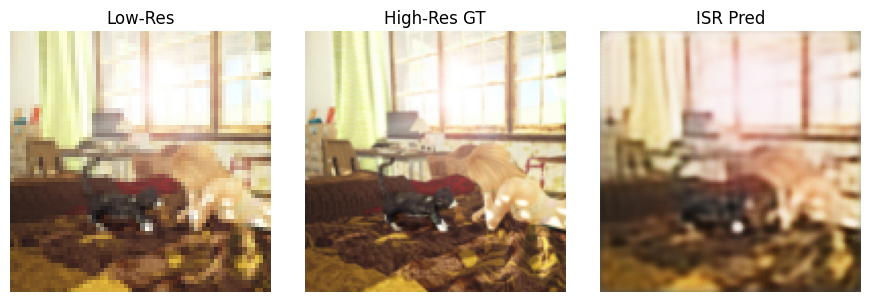

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00044693332..1.0008765].


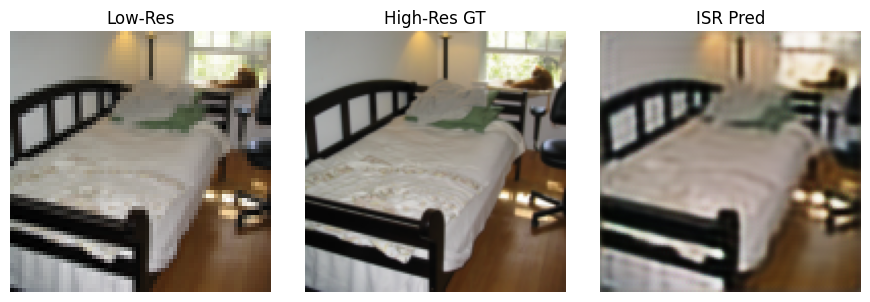

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0018245314..0.97054213].


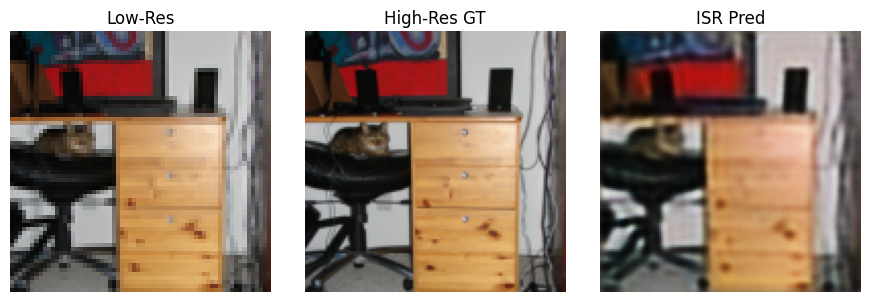

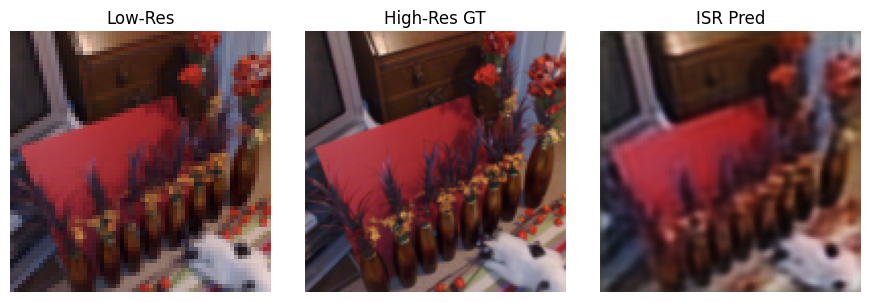

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0029987418..1.0157782].


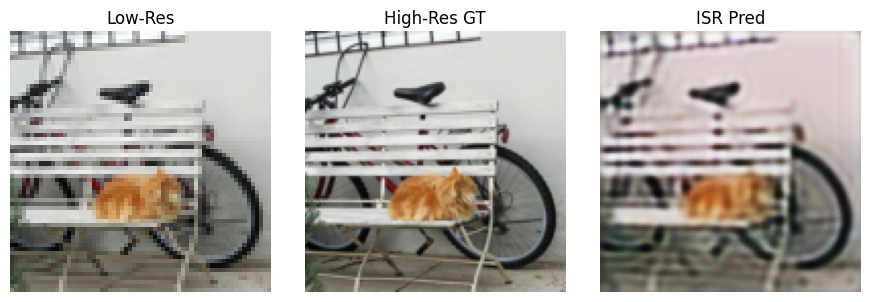

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.015960632..0.99674684].


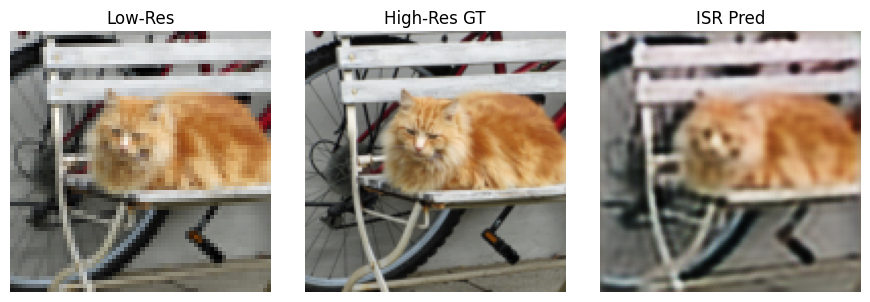

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01714358..0.93338585].


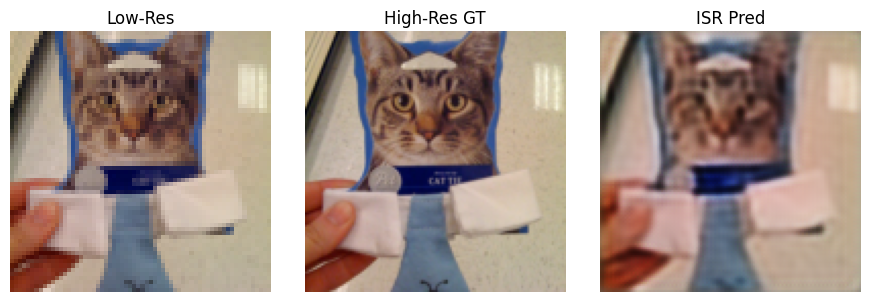

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.006930045..1.0199604].


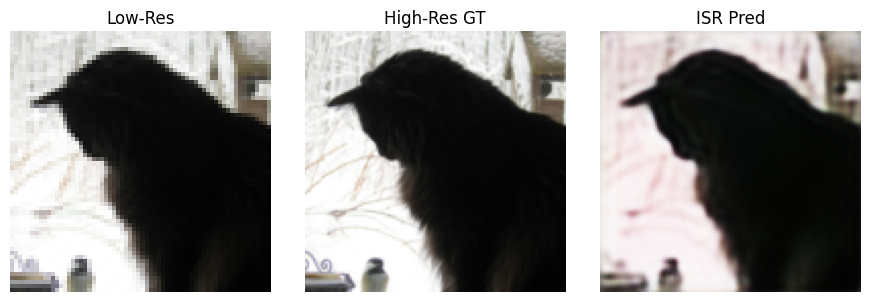

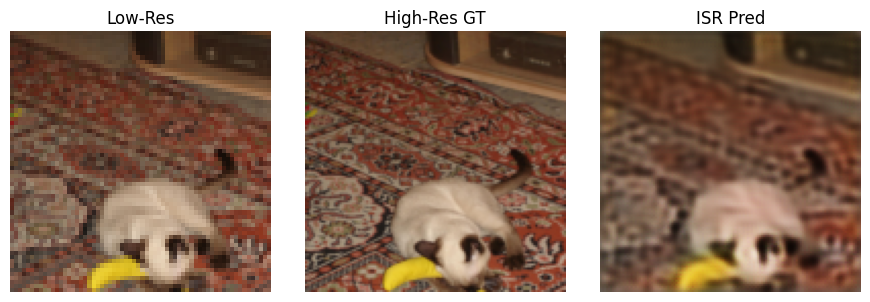

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027911555..1.0250843].


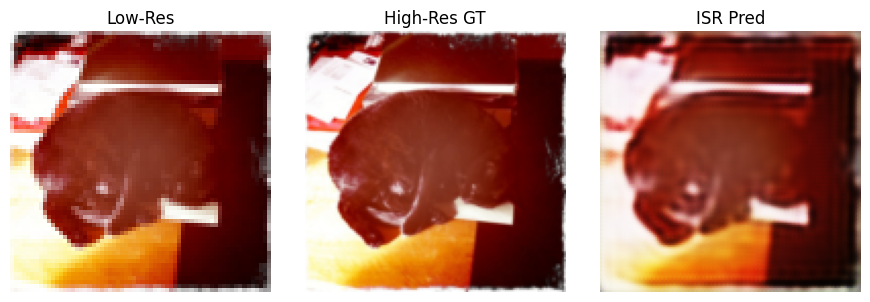

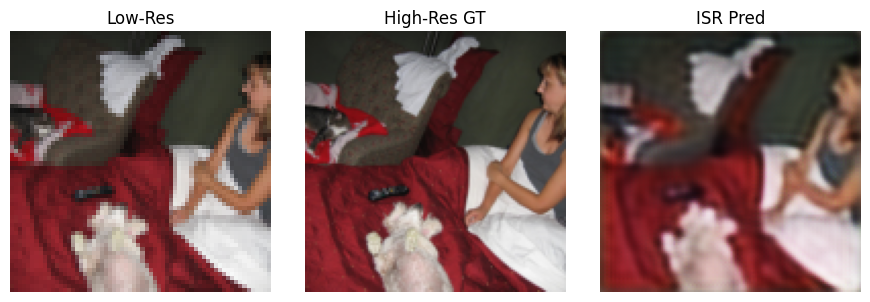

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.036002368..1.0208842].


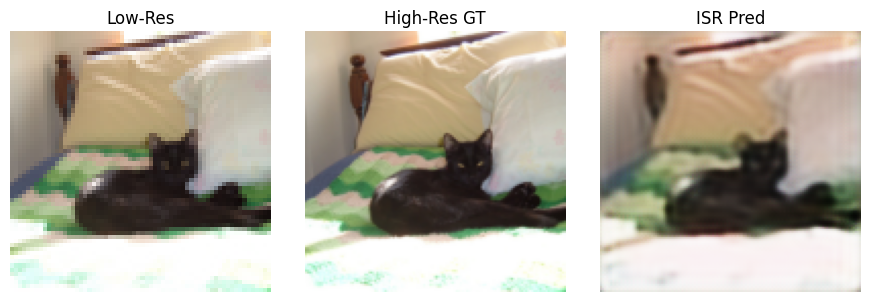

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0029035388..1.0111887].


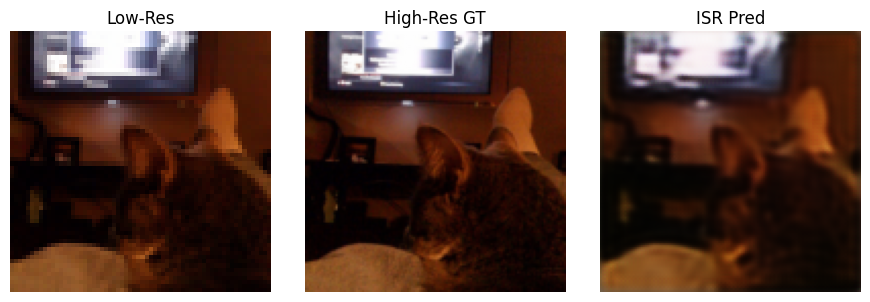

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02691836..0.97856504].


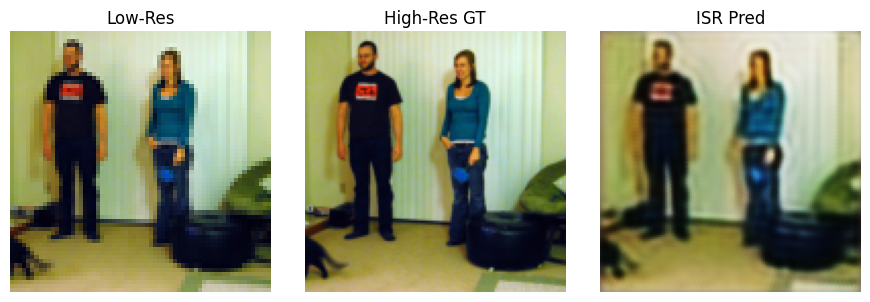

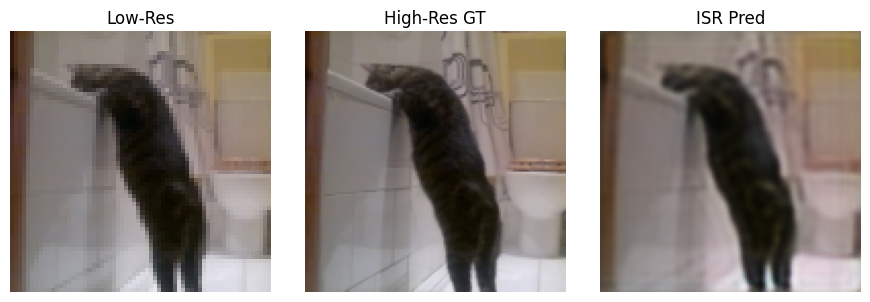

In [12]:
import matplotlib.pyplot as plt

model.eval()
low_res, high_res = next(iter(val_loader))
low_res  = low_res.to(device)
high_res = high_res.to(device)

with torch.no_grad():
    preds = model(low_res)

for i in range(15):
    # Permute für Matplotlib (C, H, W) -> (H, W, C)
    lr  = low_res[i].permute(1, 2, 0).cpu().numpy()
    hr  = high_res[i].permute(1, 2, 0).cpu().numpy()
    pr  = preds[i].permute(1, 2, 0).cpu().numpy()
    
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.title("Low-Res");  plt.imshow(lr); plt.axis("off")
    plt.subplot(1,3,2); plt.title("High-Res GT"); plt.imshow(hr); plt.axis("off")
    plt.subplot(1,3,3); plt.title("ISR Pred"); plt.imshow(pr); plt.axis("off")
    plt.tight_layout()
    plt.show()